<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/10_replicate_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replicate https://arxiv.org/abs/2010.11929

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

In [7]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image_batch.shape, image.shape, label_batch.shape, label.shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([32]),
 torch.Size([]))

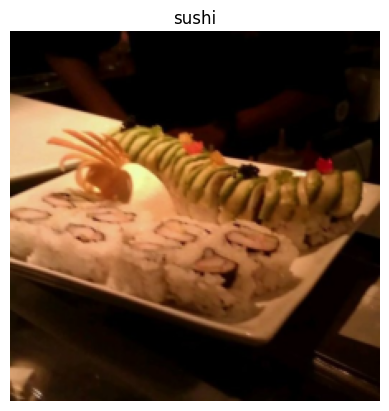

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

Input, output, layers, blocks, model  
Input>model(=block(= layer조합) 조합)>output  

  
Embedding = learnable representation

In [10]:
#input shape: (224, 224, 3) H=W=224 C=3
#N = H*W/P^(2)
#output shape: (N,P^(2)*C)
H = 224
W = 224
C = 3
P = 16

N = int(H*W/P**2)
N

196

In [11]:
input_shape = (H, W, C)
output_shape = (N, P**2*C)
input_shape, output_shape

((224, 224, 3), (196, 768))

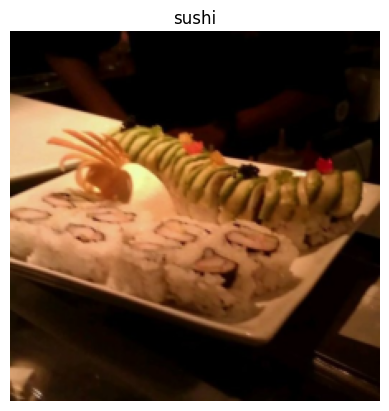

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [13]:
img_permute = image.permute(1, 2, 0) #to H,W,C
img_permute.shape

torch.Size([224, 224, 3])

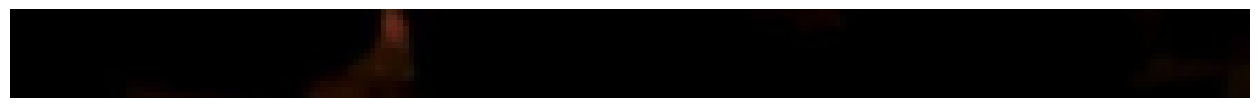

In [14]:
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permute[0:patch_size, :, :])
plt.axis(False)
plt.show()

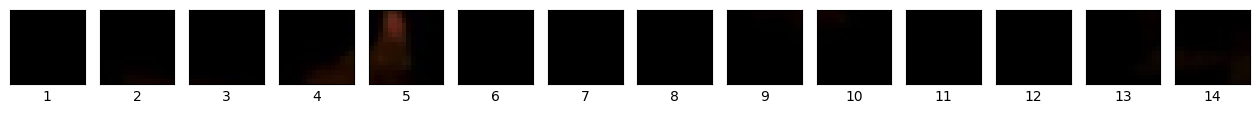

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    #print(patch)
    axs[i].imshow(img_permute[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

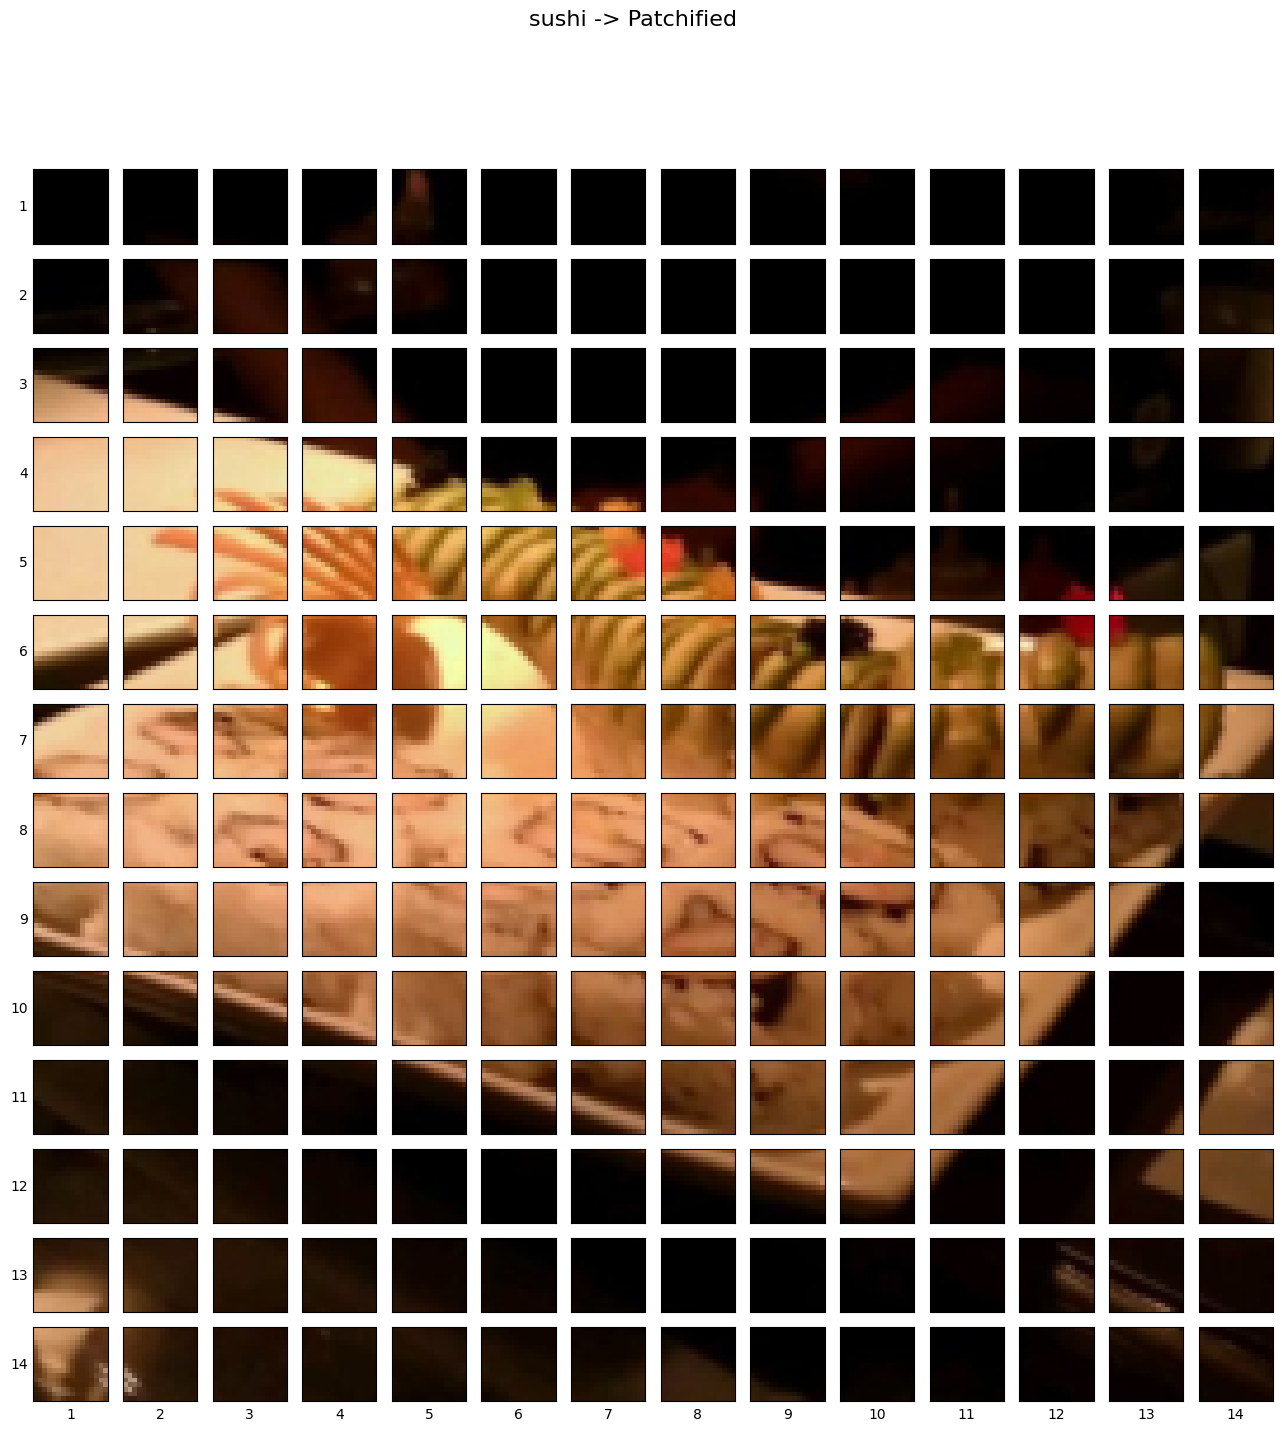

In [16]:
#img split
fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(img_permute[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i][j].set_xlabel(j+1)
        axs[i][j].set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [17]:
#img to patch
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)


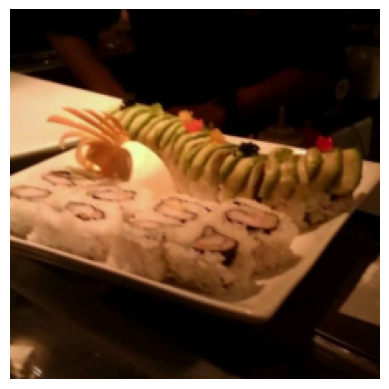

In [18]:
plt.imshow(img_permute)
plt.axis(False)
plt.show()

In [19]:
img_out_of_conv2d = conv2d(image.unsqueeze(0))
img_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

In [20]:
#flatten
img_out_of_conv2d.flatten(start_dim=2).shape

torch.Size([1, 768, 196])

In [21]:
nn.Flatten(start_dim=2)(img_out_of_conv2d).shape

torch.Size([1, 768, 196])

In [22]:
flatten_layer = nn.Flatten(start_dim=2)
flatten_layer(img_out_of_conv2d).shape

torch.Size([1, 768, 196])

In [ ]:
img_out_of_conv2d_flatten = flatten_layer(img_out_of_conv2d)
img_out_of_conv2d_flatten.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [23]:
class IMG_TO_PATCH(nn.Module):
    def __init__(self, patch_size: int, in_channels: int=3, embed_dim: int=768):
        super().__init__()
        self.patch_size = patch

        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim,
                                kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2)

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        return x

In [24]:
patch_embedding = IMG_TO_PATCH(patch_size=patch_size)
patch_embedding(image).shape

torch.Size([1, 196, 768])

In [27]:
#class token embedding
batch_size = 1
embedding_dimension = 768
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [28]:
# Add the class token embedding to the front of the patch embedding
# add >> torch.cat
patch_embedding_img_with_class_token = torch.cat((class_token, patch_embedding(image)), dim=1)
patch_embedding_img_with_class_token.shape

torch.Size([1, 197, 768])

In [30]:
patch_embedding(image)

tensor([[[-0.0253,  0.0223, -0.0237,  ..., -0.0349, -0.0030, -0.0178],
         [-0.0247,  0.0292, -0.0256,  ..., -0.0297,  0.0017, -0.0237],
         [-0.0249,  0.0269, -0.0256,  ..., -0.0348, -0.0024, -0.0167],
         ...,
         [-0.0041,  0.0424, -0.0265,  ..., -0.0244, -0.0021, -0.0217],
         [ 0.0075,  0.0551, -0.0282,  ..., -0.0243, -0.0035, -0.0208],
         [-0.0222,  0.0864, -0.0206,  ..., -0.0422,  0.0141, -0.0432]]],
       grad_fn=<PermuteBackward0>)

In [31]:
patch_embedding_img_with_class_token

tensor([[[-7.0166e-01,  1.0393e+00, -1.1478e+00,  ...,  1.6126e+00,
          -1.7905e+00,  2.5150e-01],
         [-2.5310e-02,  2.2331e-02, -2.3675e-02,  ..., -3.4912e-02,
          -3.0009e-03, -1.7783e-02],
         [-2.4667e-02,  2.9247e-02, -2.5602e-02,  ..., -2.9719e-02,
           1.6599e-03, -2.3658e-02],
         ...,
         [-4.1357e-03,  4.2380e-02, -2.6479e-02,  ..., -2.4398e-02,
          -2.1095e-03, -2.1692e-02],
         [ 7.5218e-03,  5.5072e-02, -2.8171e-02,  ..., -2.4316e-02,
          -3.5058e-03, -2.0837e-02],
         [-2.2196e-02,  8.6369e-02, -2.0555e-02,  ..., -4.2166e-02,
           1.4075e-02, -4.3166e-02]]], grad_fn=<CatBackward0>)

In [29]:
patch_embedding_img_with_class_token

tensor([[[-7.0166e-01,  1.0393e+00, -1.1478e+00,  ...,  1.6126e+00,
          -1.7905e+00,  2.5150e-01],
         [-2.5310e-02,  2.2331e-02, -2.3675e-02,  ..., -3.4912e-02,
          -3.0009e-03, -1.7783e-02],
         [-2.4667e-02,  2.9247e-02, -2.5602e-02,  ..., -2.9719e-02,
           1.6599e-03, -2.3658e-02],
         ...,
         [-4.1357e-03,  4.2380e-02, -2.6479e-02,  ..., -2.4398e-02,
          -2.1095e-03, -2.1692e-02],
         [ 7.5218e-03,  5.5072e-02, -2.8171e-02,  ..., -2.4316e-02,
          -3.5058e-03, -2.0837e-02],
         [-2.2196e-02,  8.6369e-02, -2.0555e-02,  ..., -4.2166e-02,
           1.4075e-02, -4.3166e-02]]], grad_fn=<CatBackward0>)